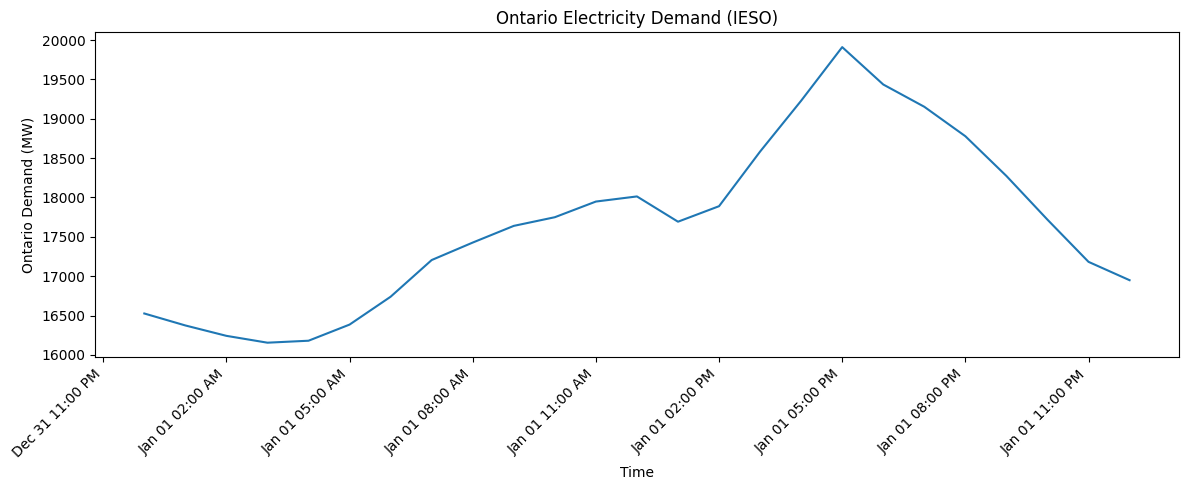

Saved cleaned data to ..\data\processed\ontario_demand_hourly.csv


In [23]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---------- Load CSV ----------
csv_path = Path("../data/raw/PUB_Demand.csv")

raw = pd.read_csv(csv_path, header=None, dtype=str)

# Detect header row
header_row = None
for i in range(min(len(raw), 50)):
    row = raw.iloc[i].fillna("").astype(str).str.lower()
    if "date" in row.tolist() and "hour" in row.tolist():
        header_row = i
        break

if header_row is None:
    raise ValueError("Header row not found")

df = raw.iloc[header_row + 1:].copy()
df.columns = raw.iloc[header_row]
df.columns = [c.replace("\\", "").strip() for c in df.columns]
df = df.reset_index(drop=True)

# Convert types
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Hour"] = pd.to_numeric(df["Hour"], errors="coerce")
df["Ontario Demand"] = pd.to_numeric(df["Ontario Demand"], errors="coerce")

df = df.dropna(subset=["Date", "Hour", "Ontario Demand"])

# Build timestamp (Hour 1 = 12:00 AM)
df["timestamp"] = df["Date"] + pd.to_timedelta(df["Hour"] - 1, unit="h")
df = df.sort_values("timestamp")

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df["timestamp"], df["Ontario Demand"])

ax.set_title("Ontario Electricity Demand (IESO)")
ax.set_xlabel("Time")
ax.set_ylabel("Ontario Demand (MW)")

# ---- Readable 12-hour time with AM/PM ----
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d %I:%M %p"))

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()


processed_path = Path("../data/processed/ontario_demand_hourly.csv")
df.to_csv(processed_path, index=False)
print(f"Saved cleaned data to {processed_path}")



## 2. Daily Demand Summary


In [24]:
# --- Daily demand summary statistics ---

# Create a date-only column
df["date_only"] = df["timestamp"].dt.date

# Aggregate daily stats
daily_summary = (
    df.groupby("date_only")["Ontario Demand"]
      .agg(
          min_demand="min",
          max_demand="max",
          avg_demand="mean"
      )
      .reset_index()
)

daily_summary


,date_only,min_demand,max_demand,avg_demand
0,2026-01-01,16155,19910,17684.291667
1,2026-01-02,16949,16949,16949.000000


## 3. Average Daily Load Profile


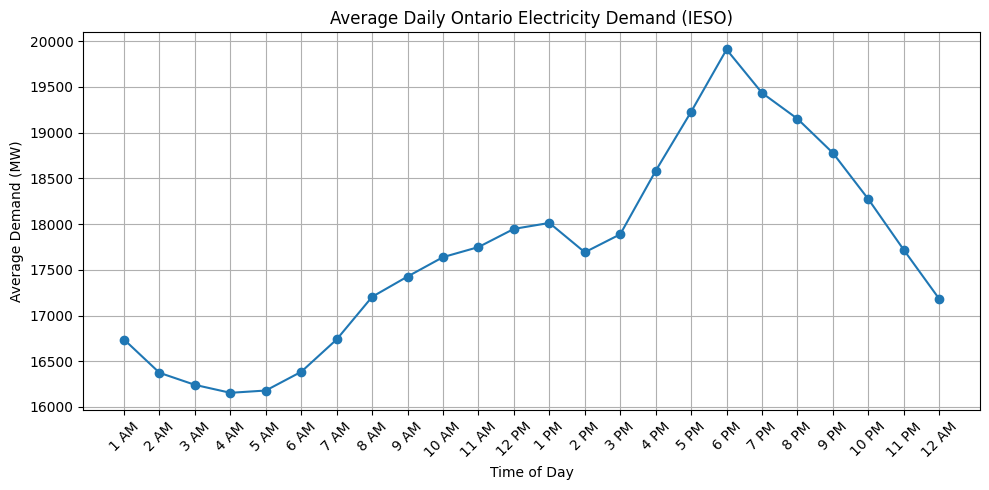

In [25]:
import matplotlib.pyplot as plt

# --- Average Daily Load Profile ---

# Group by hour and compute average Ontario demand
hourly_profile = (
    df.groupby("Hour")["Ontario Demand"]
      .mean()
      .reset_index()
)

# Convert hour (1–24) to readable AM/PM labels
def hour_to_ampm(hour):
    if hour == 24 or hour == 0:
        return "12 AM"
    elif hour < 12:
        return f"{hour} AM"
    elif hour == 12:
        return "12 PM"
    else:
        return f"{hour - 12} PM"

hourly_profile["Time"] = hourly_profile["Hour"].apply(hour_to_ampm)

# Clean up table
hourly_profile["Ontario Demand"] = hourly_profile["Ontario Demand"].round(0)
hourly_profile = hourly_profile[["Time", "Ontario Demand"]]

# Display table
hourly_profile

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(
    hourly_profile["Time"],
    hourly_profile["Ontario Demand"],
    marker="o"
)

plt.title("Average Daily Ontario Electricity Demand (IESO)")
plt.xlabel("Time of Day")
plt.ylabel("Average Demand (MW)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Peak vs Off-Peak Demand Analysis


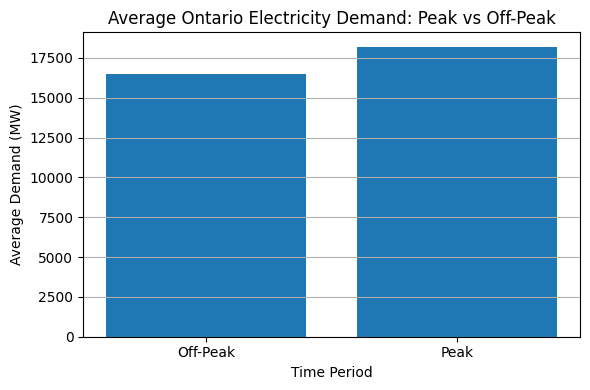

In [26]:
import matplotlib.pyplot as plt

# --- Step 4: Peak vs Off-Peak Analysis ---

# Define peak and off-peak hours
peak_hours = list(range(7, 24))     # 7 AM to 11 PM
offpeak_hours = [1, 2, 3, 4, 5, 6, 24]

# Create a new column for period type
df["Period"] = df["Hour"].apply(
    lambda h: "Peak" if h in peak_hours else "Off-Peak"
)

# Compute average demand by period
period_summary = (
    df.groupby("Period")["Ontario Demand"]
      .mean()
      .reset_index()
)

# Round for readability
period_summary["Ontario Demand"] = period_summary["Ontario Demand"].round(0)

# Display table
period_summary

# --- Plot ---
plt.figure(figsize=(6, 4))
plt.bar(
    period_summary["Period"],
    period_summary["Ontario Demand"]
)

plt.title("Average Ontario Electricity Demand: Peak vs Off-Peak")
plt.ylabel("Average Demand (MW)")
plt.xlabel("Time Period")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


## 5. Ontario Demand vs Market Demand


In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# --- Step 5: Compare Ontario Demand vs Market Demand over time ---

plt.figure(figsize=(10, 4))
plt.plot(df["timestamp"], df["Ontario Demand"], label="Ontario Demand")
plt.plot(df["timestamp"], df["Market Demand"], label="Market Demand")

plt.title("Ontario Demand vs Market Demand (IESO)")
plt.ylabel("Demand (MW)")
plt.xlabel("Time")
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %I %p"))

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.legend()
plt.show()

# Quick numeric comparison
comparison = df[["Ontario Demand", "Market Demand"]].describe().round(1)
display(comparison)
